# FlagShip
##### Author: Samuel Moran 

In [1]:
# Import necessary libraries
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import os, os.path
import datetime
%matplotlib inline

In [2]:
def dataPrep(r):
    
    # Prepare the data: sort values from least recent to most recent
    data = (((pd.DataFrame.from_dict(r).head(5)).sort_values(by=['fillingDate'])).reset_index()).tail()

    # Combine SellingAndMarketing and generalAndAdministrative into one SGA Cost
    data['SellingGeneralAdministrative'] = data.apply(lambda row: row.generalAndAdministrativeExpenses + (row.sellingAndMarketingExpenses), axis=1)

    # Provide SGA costs as a percentage of Gross Profits
    data['SGA_%_GP'] = data.apply(lambda row: (row.SellingGeneralAdministrative / row.grossProfit)*100, axis=1)

    # Provide R&D costs as a percentage of Gross Profits
    data['RD_%_GP'] = data.apply(lambda row: (row.researchAndDevelopmentExpenses / row.grossProfit)*100, axis=1)

    # Provide GrossProfitMargin in a 'percentage' form
    data['grossProfitMargin'] = data.apply(lambda row: row.grossProfitRatio * 100,axis=1)

    # Provide Net Earnings as a percentage of Revenue
    data['NE_%_RV'] = data.apply(lambda row: (row.netIncome / row.revenue) * 100,axis=1)
    
    # Provide Depreciation as a percentage of Gross Profits
    data['Depreciation_%_GP'] = data.apply(lambda row: (row.depreciationAndAmortization / row.grossProfit) * 100, axis=1)
    
    # Provide Interest Expense as a percentage of Operating Income
    data['InterestExpense_%_OperatingIncome'] = data.apply(lambda row: (row.interestExpense / row.operatingIncome) * 100, axis=1)
    
    # Remove non-recurring expenses from the Net Earnings 
    data['RecurringNetEarnings'] = data.apply(lambda row: (row.netIncome - row.totalOtherIncomeExpensesNet), axis=1)
    
    # Include Income Before Tax vs Reported Income Before Tax Here
        
    
    return data

In [21]:
def graph(x, plots, companyTicker):
    
    fig, axs = plt.subplots(len(plots),figsize=(20,45))
    fig.suptitle(companyTicker)
    fig.tight_layout(pad=8.0)
    counter = 0
    for plot in plots:
        
        for line in plots[plot]:
        
            axs[counter].plot(x,data[str(line)])
    
        axs[counter].set_xlabel("Time (Years)")
        axs[counter].set_ylabel("$ USD (Billions)")
        axs[counter].set_title(str(plot))
        axs[counter].legend(plots[plot],loc="upper right")
        counter+=1

In [4]:
def getX(data):
    
    # Get the past five dates (in years) for the x-axis
    dates = []
    for i in data['fillingDate']:
        date = i.split("-")[0]
        dates.append(date)

    return [dt.datetime.strptime(d,'%Y').date() for d in dates]

In [23]:
def getPlots(target):
    
    if target == "Income Statement":
        return { "RevenueGrossAndNetIncome":["revenue","grossProfit","netIncome"],
          "SGA_R&D_AsPercentGrossProfits": ["SGA_%_GP","RD_%_GP"],
         "GrossProfitMargin_OverTime": ["grossProfitMargin"],
         "NetEarnings_%_Revenue":["NE_%_RV"],
         "EarningsPerShare":["eps"],
        "Depreciation_%_GrossProfits":["Depreciation_%_GP"],
        "InterestExpense_%_OperatingIncome":["InterestExpense_%_OperatingIncome"],
        "RecurringNetEarnings v. ReportedNetEarnings":["RecurringNetEarnings", "netIncome"]
        }    

In [6]:
def getData(ticker):
    
    # Retrieve local API key from file (---this file is not to be pushed to GitHub for security reasons ---)
    keyFile="/home/wintergreen/Projects/fskeyfile.txt"
    with open(keyFile) as f:
        key = str(f.readline().replace("\n",""))
    API_KEY = key
    TICKER_TARGET = ticker
    URL = "https://financialmodelingprep.com/api/v3/income-statement/" + TICKER_TARGET + "?limit=120&apikey=" + API_KEY
    return requests.get(URL).json()

In [7]:
def checkCache(ticker):
    
    TICKER=ticker
    fileStorage = "/home/wintergreen/Projects/file-cache/"
    arr = os.listdir(fileStorage)
    
    for file in arr:
        if file.split("-")[0] == TICKER:
            if file.split("-")[1] == "10K":
                if str(int(datetime.datetime.now().year)-1) in file.split("-")[2]:
                    print("Pulling from cache...")
                    return pd.read_csv(os.path.join(fileStorage,file))
                    
        else:
            continue
    
    print("Need to write to cache")
    
    #Return this
    r = getData(ticker)
    
    #Save file to cache
    saveToCache(ticker, r)
    
    return r

In [8]:
def saveToCache(ticker, file):
    savePath = "/home/wintergreen/Projects/file-cache/"
    fileName = str(ticker)+"-10K-"+str(int(datetime.datetime.now().year)-1)
    completeName = os.path.join(savePath, fileName+".csv")
    outFile=open(completeName,"w")
    df = pd.DataFrame.from_dict(file).to_csv()
    outFile.write(df)
    outFile.close()

In [9]:
def retrieveInformation(ticker):
    return checkCache(ticker)

### Display Graphs

Pulling from cache...


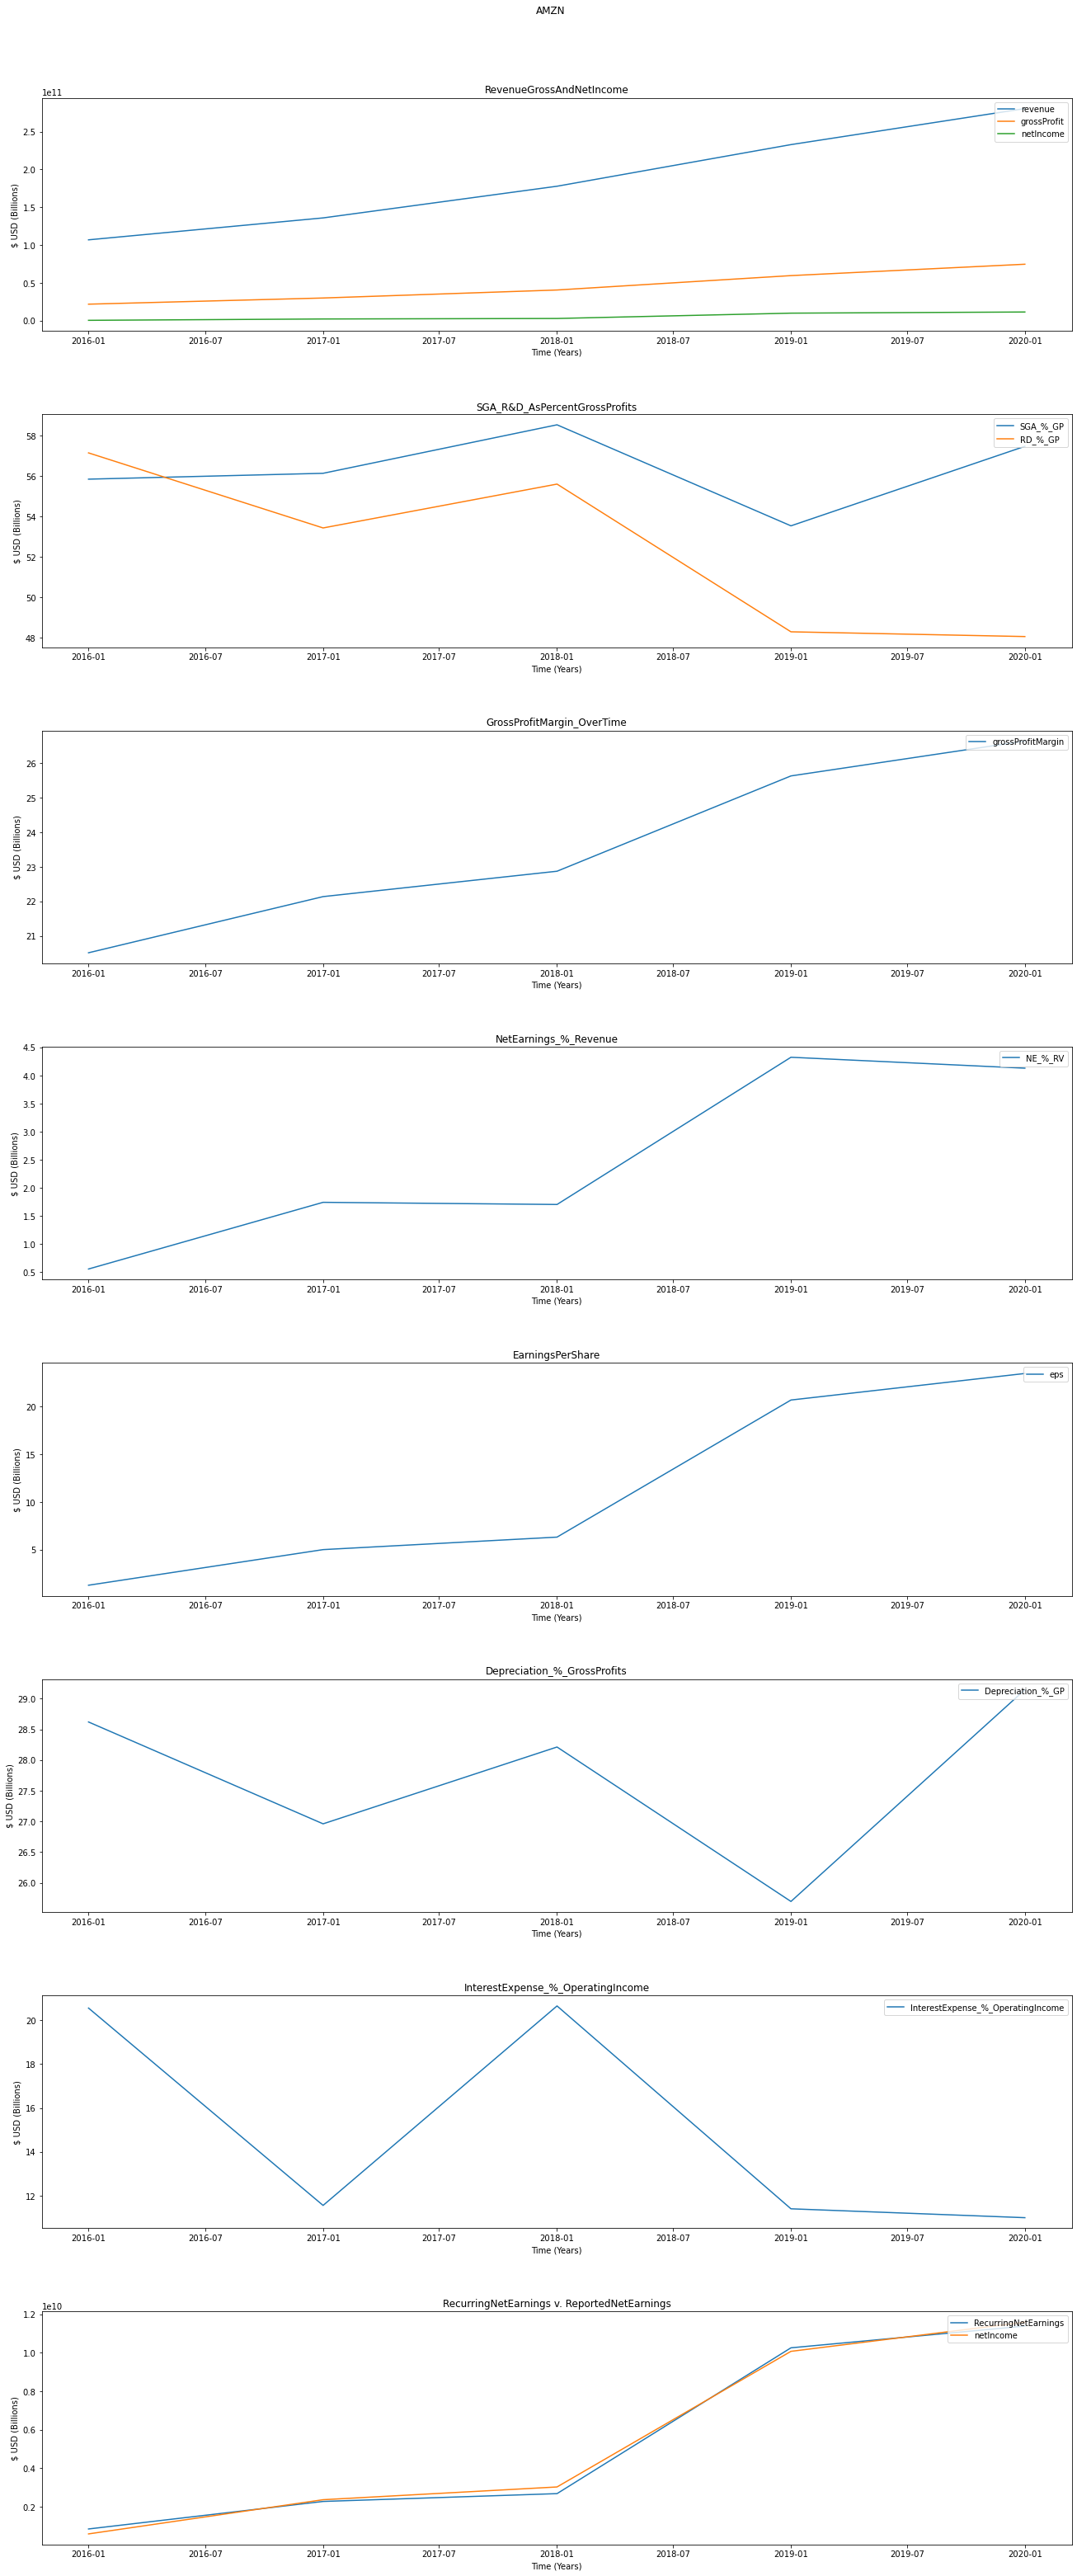

In [24]:
# Make request for data

companyTicker = "AMZN"

r = retrieveInformation(companyTicker)

#pd.DataFrame.from_dict(r).head(5)
#print(r.columns)

# Prepare the data
data = dataPrep(r)

# Plot the data
x = getX(data)

plots = getPlots("Income Statement")

# Plot these in graphical form as subplots
graph(x, plots, companyTicker)